# Make Your Own Database

The `cosima-cookbook` uses a database to access information about experiments and to help with loading model output. We maintain a default database for ACCESS-OM2 experiments, but there are occasions when you might want to make your own database. This tutorial outlines the process of making your own private database.

**Requirements:** We recommend that you use `conda/analysis3-21.04` (or later) kernel on NCI (or your own up-to-date `cosima-cookbook` installation).

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import intake
catalog = intake.cat.access_nri

**First, create a database session** using the inbuilt `create_session` function. To do this, you need to specify a path for the database - choose a location where you have write permission (that is, not the example that I have given here):

In [2]:
db = 'local_cc_test.db'
session = cc.database.create_session(db)

Note that you need to create the database session every time you start up your notebook; you can then update this database however many times you like.

**Now you are ready to build a database.** First, select which *experiments* you want to include in your database. For these purposes, an *experiment* is a directory containing output from a single simulation. (If you use a higher level directory you won't be able to distinguish between experiments.) 

My example below constructs a list of two experiment directories; we have chosen two cases with different resolution. The database will be built to index all netcdf files in each directory.

In [3]:
directory_list=['/g/data/ik11/outputs/access-om2/1deg_jra55_iaf_omip2_cycle6',
                '/g/data/ik11/outputs/access-om2-025/025deg_jra55_iaf_omip2_cycle6'
               ]

cc.database.build_index(directory_list, session)

Indexing experiment: 1deg_jra55_iaf_omip2_cycle6


100%|██████████| 4376/4376 [05:15<00:00, 13.85it/s]


Indexing experiment: 025deg_jra55_iaf_omip2_cycle6


100%|██████████| 2174/2174 [11:54<00:00,  3.04it/s]


6550

Some warnings could come up. If they look worrisome then seek for advice. 🙂

Note that when you index your database for the first time it may take a little as it has to go through all output files of the experiments. However, it is relatively painless to update the database to include more output from some of the experiments.

By default, the next time you call `cc.database.build_index` using the same session, the database won't be reindexed but only new files will be updated. If you **do not want to update** the database but rather want to **force the whole database to be re-indexed**, then you need to provide the `force=True` keyword argument to `cc.database.build_index`. For more details on usage of `cc.database.build_index`, have a look at `help(cc.database.build_index)`.

You now have your own database! 🎉

Just remember to **specify** your own database via the `cc.database.create_session()` when you load model output to do your analyses. Otherwise, the `cosima-cookbook` will look for the output from the experiment you prescribed from the default database.

## Using the database
To know how to effectively use this database, please see the companion tutorial: [`COSIMA_CookBook_Tutorial.ipynb`](https://cosima-recipes.readthedocs.io/en/latest/tutorials/COSIMA_CookBook_Tutorial.html#gallery-tutorials-cosima-cookbook-tutorial-ipynb). Alternatively, here is a sample that shows how you might load a variable from an experiment in your database.

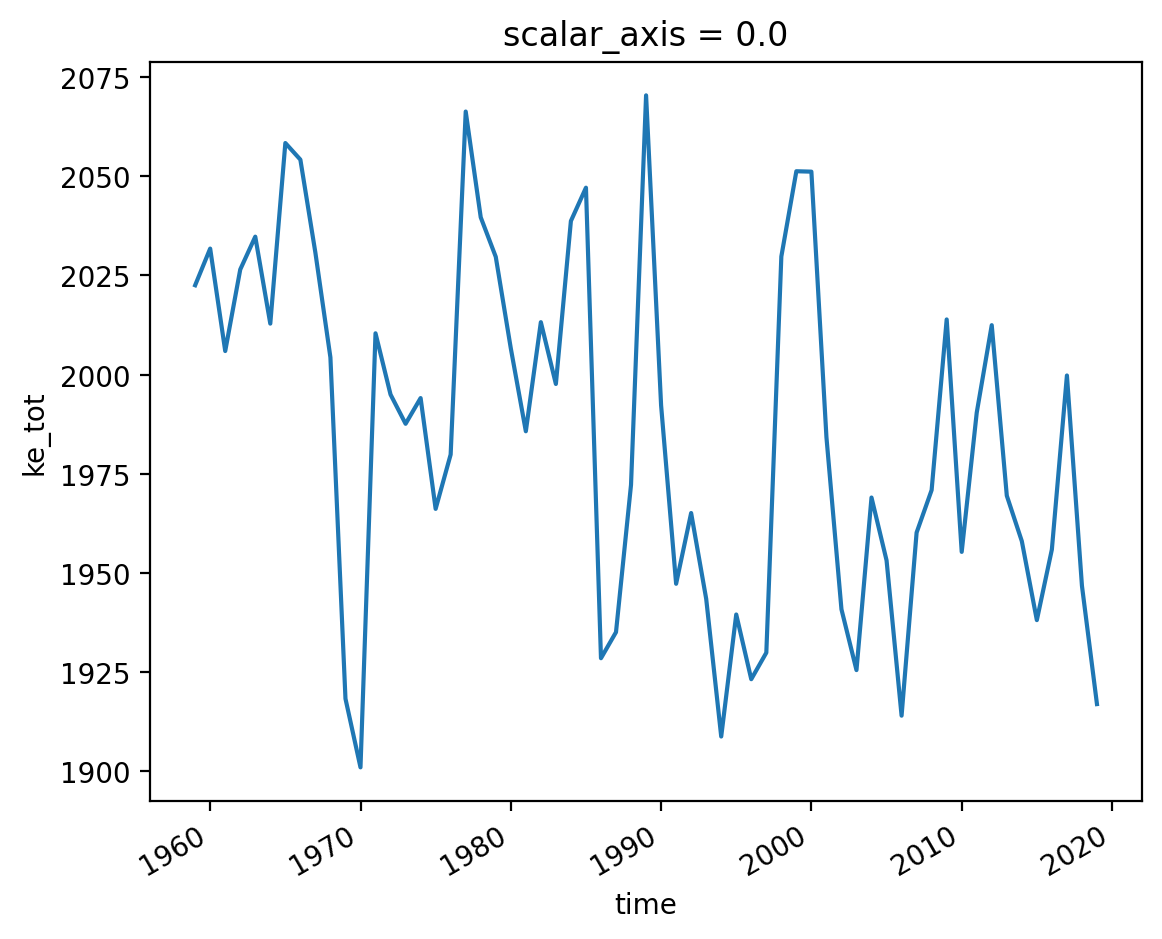

In [5]:
experiment = '025deg_jra55_iaf_omip2_cycle6'
variable = 'ke_tot'
cat_subset = catalog[experiment]
var_search = cat_subset.search(variable=variable)
darray = var_search.to_dask()
darray = darray[variable]
dataarray = darray
annual_average = dataarray.resample(time='A').mean(dim='time')
annual_average.plot();

To find more about the in-built functions used above, you can use the `help` function. For example:

In [6]:
help(cc.database.create_session)

Help on function create_session in module cosima_cookbook.database:

create_session(db=None, debug=False)
    Create a session for the specified database file.
    
    If debug=True, the session will output raw SQL whenever it is executed on the database.



In [8]:
help(cc.querying.getvar)

Help on function getvar in module cosima_cookbook.querying:

getvar(expt, variable, session, ncfile=None, start_time=None, end_time=None, n=None, frequency=None, attrs={}, **kwargs)
    For a given experiment, return an xarray DataArray containing the
    specified variable.
    
    expt - text string indicating the name of the experiment
    variable - text string indicating the name of the variable to load
    session - a database session created by cc.database.create_session()
    ncfile -  an optional text string indicating the pattern for filenames
              to load. All filenames containing this string will match, so
              be specific. '/' can be used to match the start of the
              filename, and '%' is a wildcard character.
    start_time - only load data after this date. specify as a text string,
                 e.g. '1900-01-01'
    end_time - only load data before this date. specify as a text string,
               e.g. '1900-01-01'
    n - after all oth